In [1]:
from netgen.geom2d import SplineGeometry
from ngsolve import Mesh
from typing import Optional
import matplotlib.pyplot as plt
import numpy as np

In [2]:
R = 10.
H = 1.



geo = SplineGeometry()
geo.AddRectangle(p1=(-R,-H),
                 p2=( R, H),
                 bc="rectangle",
                 leftdomain=1,
                 rightdomain=0)
geo.AddCircle(c=(0,0),
              r=0.4,
              bc="dOmega",
              leftdomain=2,
              rightdomain=1)
geo.SetMaterial (1, "background")
geo.SetMaterial (2, "scatterer")

In [3]:
ngmesh = geo.GenerateMesh(maxh=2.)
Omega = Mesh(ngmesh)

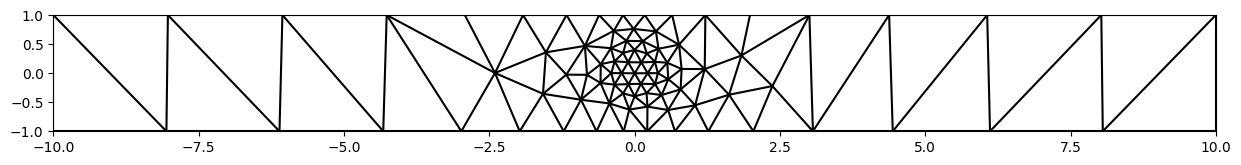

In [4]:
def plot_mesh( M : Mesh, ax : Optional[plt.Axes] = None ): 
    """Plots a mesh"""
    points = np.fromiter( (v.point for v in M.vertices), dtype=np.dtype((float, 2)), count=M.nv)
    
    if ax is None:
        _, ax = plt.subplots( figsize=(15,3))
    for l in M.edges:
        px, py = points[l.vertices[0].nr]
        qx, qy = points[l.vertices[1].nr]
        ax.plot( [px, qx], [py, qy], 'k')

    #ax.scatter(x=points[:,0], y=points[:,1])

    ax.axis('square')
    ax.set_xlim([-R,R])
    ax.set_ylim([-H,H])


plot_mesh(Omega)

I will create three arrays, one which indicates the number of plane waves per element, another one with the coefficients and another one with their ownership.

In [5]:
class TrefftzFun:
    def __init__( self, Omega : Mesh, Np : list[int], kappa : list[float]):
        assert Omega.ne == len(Np)
        self.Ncoef = sum(Np) 
        self.Np = Np
        self.coefs = np.zeros(self.Ncoef, dtype=np.complex128)
        #self.index = np.zeros(self.Ncoef, dtype=np.int32)
        self.kappa = kappa
        #i=0
        #for e in range(Omega.ne):
        #    self.index[i:i+Np[e]] = e
        #    i=i+Np[e]

        self.e_to_coef = np.zeros( (Omega.ne,2), dtype=np.int32)
        i = 0
        for e in range(Omega.ne):
            self.e_to_coef[e,:] = np.array( i, Np[e])
            i += Np[e]
    

    def set_coeffs( self, coeffs):
        self.coefs = coeffs


    def __call__(self, x, y ):
        e_ID = Omega(x,y).nr
        k = self.kappa[e_ID]
        id0 = self.e_to_coef[e_ID,0]
        y = sum( [self.coefs[id0+n] * np.exp(1j*k*(x*np.cos(th) + y*np.sin(th))) 
                  for (n,th) in enumerate(np.linspace(0,2*np.pi, self.Np[e_ID], endpoint=False))] )
        return y 



In [6]:
Nth = 3
Np = np.full(Omega.ne, Nth, dtype=np.int32) #homogeneous number of plane waves
kappa = [ 8 if e.mat == "background" else 20 for e in Omega.Elements()]
f = TrefftzFun(Omega, Np, kappa)

In [7]:
#f.set_coeffs(np.tile([1,0],Omega.ne))
coeffs = np.random.randint(10,size=Nth*Omega.ne)
#coeffs = np.random.uniform(-1, 1, Nth*Omega.ne) + 1.j * np.random.uniform(-1, 1, Nth*Omega.ne)

f.set_coeffs(coeffs)

In [8]:
Ny = 50
Nx = 10*Ny
x = np.linspace(-R,R,Nx)
y = np.linspace(-H,H,Ny)
X, Y = np.meshgrid(x,y)

Z =  np.reshape([ f(x_, y_) for x_, y_ in zip( X.ravel(), Y.ravel()) ], [Ny,Nx])



(-1.0, 1.0)

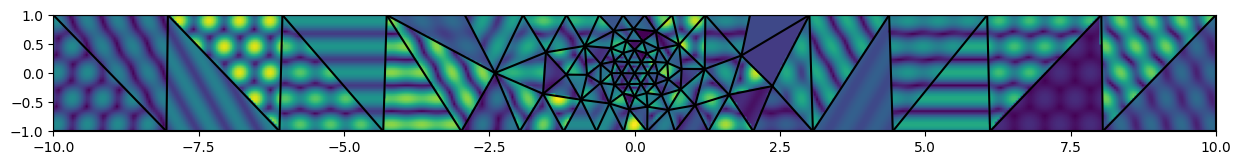

In [9]:
_, ax = plt.subplots( figsize=(15,3))
ax.imshow(np.abs(Z), origin="lower", extent=[-R,R,-H,H])
plot_mesh(Omega, ax)
ax.axis('square')
ax.set_xlim([-R,R])
ax.set_ylim([-H,H])


(-1.0, 1.0)

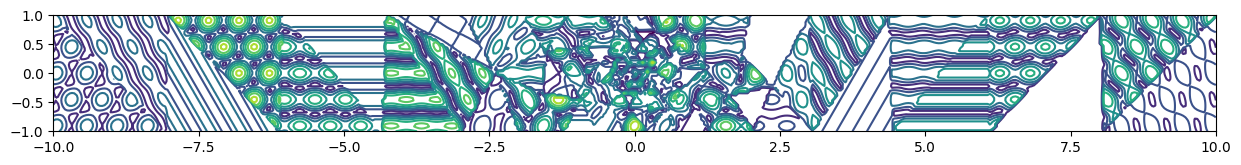

In [10]:
_, ax = plt.subplots( figsize=(15,3))
ax.contour(X,Y,np.abs(Z))
ax.axis('square')
ax.set_xlim([-R,R])
ax.set_ylim([-H,H])
